In [ ]:
# Cài đặt các thư viện cần thiết
!pip install -q datasets huggingface_hub pyarrow pandas polars

# Import libraries
from datasets import load_dataset, Dataset, DatasetDict  # Dòng này đúng
from dataclasses import dataclass, field                 # Dòng này import dataclass và field
from huggingface_hub import hf_hub_download

from typing import Literal

import pandas as pd
import polars as pl

import gc
import time
import os
from pathlib import Path
import psutil

In [ ]:
import psutil

# Check available memory
mem = psutil.virtual_memory()
print(f"Total RAM: {mem.total / 1e9:.2f} GB")
print(f"Available RAM: {mem.available / 1e9:.2f} GB")
print(f"Used RAM: {mem.used / 1e9:.2f} GB")
print(f"RAM Usage: {mem.percent}%")

Total RAM: 56.86 GB
Available RAM: 54.69 GB
Used RAM: 1.52 GB
RAM Usage: 3.8%


In [ ]:
print("⬇️ Downloading file directly...")
local_file_path = hf_hub_download(
    repo_id="yandex/yambda",
    filename="flat/500m/listens.parquet",
    repo_type="dataset",
    local_dir="/content/temp_data" # Tải vào thư mục tạm
)
print(f"✅ File downloaded to: {local_file_path}")

⬇️ Downloading file directly...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


flat/500m/listens.parquet:   0%|          | 0.00/3.68G [00:00<?, ?B/s]

✅ File downloaded to: /content/temp_data/flat/500m/listens.parquet


In [ ]:
# Lazy load - không load hết vào RAM
print("🔄 Lazy loading with Polars...")

df_lazy = pl.scan_parquet(local_file_path)

print("✅ Lazy DataFrame created (data not loaded yet)")
print(f"Schema: {df_lazy.schema}")

🔄 Lazy loading with Polars...
✅ Lazy DataFrame created (data not loaded yet)


/tmp/ipython-input-2573230858.py:7: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  print(f"Schema: {df_lazy.schema}")


Schema: Schema({'uid': UInt32, 'timestamp': UInt32, 'item_id': UInt32, 'is_organic': UInt8, 'played_ratio_pct': UInt16, 'track_length_seconds': UInt32})


In [ ]:
print("=" * 80)
print("📊 YAMBDA-500M DATASET - EXPLORATORY DATA ANALYSIS (MAXPING EDITION)")
print("=" * 80)

# Gom tất cả vào 1 query duy nhất để chỉ đọc file 1 lần
# Dùng approx_n_unique để không bao giờ tràn RAM
stats = df_lazy.select([
    pl.len().alias("count"),  # Đếm dòng (siêu nhanh)
    pl.col("uid").approx_n_unique().alias("unique_users"), # HyperLogLog++ (Tốn ít KB RAM)
    pl.col("item_id").approx_n_unique().alias("unique_items"),
    pl.col("timestamp").min().alias("min_timestamp"),
    pl.col("timestamp").max().alias("max_timestamp"),
]).collect(streaming=True) # Kích hoạt Streaming Engine

# Lấy kết quả ra (vì stats chỉ có 1 dòng duy nhất)
row = stats.row(0)
# Mapping tên cột với vị trí hoặc dùng stats['col'][0]
n_rows = row[0]
n_users = row[1]
n_items = row[2]
min_ts = row[3]
max_ts = row[4]

print("\n1. DATASET OVERVIEW")
print("-" * 80)
print(f"Total interactions: {n_rows:,}")
print(f"Unique users (approx): {n_users:,}")
print(f"Unique items (approx): {n_items:,}")
print(f"Timestamp range: {min_ts:,} - {max_ts:,}")

# Calculate time span
time_span_days = (max_ts - min_ts) * 5 / (60 * 60 * 24)
print(f"Data collection period: ~{time_span_days:.1f} days")

📊 YAMBDA-500M DATASET - EXPLORATORY DATA ANALYSIS (MAXPING EDITION)


/tmp/ipython-input-2269384892.py:13: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ]).collect(streaming=True) # Kích hoạt Streaming Engine



1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Total interactions: 466,512,103
Unique users (approx): 93,695
Unique items (approx): 2,773,592
Timestamp range: 0 - 26,000,000
Data collection period: ~1504.6 days


In [ ]:
print("\n2. INTERACTION STATISTICS (MAXPING EDITION)")
print("-" * 80)

# Aggregate stats - all computed in one pass with STREAMING
interaction_stats = df_lazy.select([
    # Organic vs Recommendation (Nhẹ - OK)
    pl.col("is_organic").sum().alias("organic_count"),
    pl.col("is_organic").mean().alias("organic_ratio"),

    # Played ratio stats
    pl.col("played_ratio_pct").mean().alias("avg_played_ratio"),

    # 🔥 TỐI ƯU MEDIAN:
    # Cách 1 (An toàn nhất): Dùng approx_quantile(0.5) -> Tốn cực ít RAM, siêu nhanh
    # pl.col("played_ratio_pct").approx_quantile(0.5).alias("median_played_ratio"),

    # Cách 2 (Chính xác): Giữ nguyên median nhưng BẮT BUỘC dùng streaming=True ở dưới
    pl.col("played_ratio_pct").median().alias("median_played_ratio"),

    pl.col("played_ratio_pct").min().alias("min_played_ratio"),
    pl.col("played_ratio_pct").max().alias("max_played_ratio"),
    pl.col("played_ratio_pct").std().alias("std_played_ratio"), # std cũng cần đi qua 2 pass hoặc thuật toán Welford

    # Track length stats
    pl.col("track_length_seconds").mean().alias("avg_track_length"),
    pl.col("track_length_seconds").median().alias("median_track_length"),

    # Engagement metrics (Filter logic ngay trong select -> Rất tốt, Maxping)
    (pl.col("played_ratio_pct") >= 100).sum().alias("full_listens"),
    (pl.col("played_ratio_pct") >= 50).sum().alias("half_listens"),
    (pl.col("played_ratio_pct") < 10).sum().alias("skips"),

]).collect(streaming=True) # <--- QUAN TRỌNG NHẤT: Kích hoạt engine xử lý theo lô

print(f"\n📌 Organic vs Recommendation:")
organic_count = interaction_stats['organic_count'][0]
organic_ratio = interaction_stats['organic_ratio'][0]
print(f"   Organic interactions: {organic_count:,} ({organic_ratio*100:.2f}%)")
print(f"   Recommendation-driven: {n_rows - organic_count:,} ({(1-organic_ratio)*100:.2f}%)")

print(f"\n📌 Listening Behavior:")
print(f"   Avg played ratio: {interaction_stats['avg_played_ratio'][0]:.2f}%")
print(f"   Median played ratio: {interaction_stats['median_played_ratio'][0]:.2f}%")
print(f"   Std dev: {interaction_stats['std_played_ratio'][0]:.2f}%")
print(f"   Range: {interaction_stats['min_played_ratio'][0]:.0f}% - {interaction_stats['max_played_ratio'][0]:.0f}%")

print(f"\n📌 Track Characteristics:")
avg_length = interaction_stats['avg_track_length'][0]
print(f"   Avg track length: {avg_length:.0f}s ({avg_length/60:.1f} min)")
print(f"   Median track length: {interaction_stats['median_track_length'][0]:.0f}s")

print(f"\n📌 Engagement Metrics:")
full = interaction_stats['full_listens'][0]
half = interaction_stats['half_listens'][0]
skips = interaction_stats['skips'][0]
print(f"   Full listens (≥100%): {full:,} ({full/n_rows*100:.2f}%)")
print(f"   Half+ listens (≥50%): {half:,} ({half/n_rows*100:.2f}%)")
print(f"   Skips (<10%): {skips:,} ({skips/n_rows*100:.2f}%)")


2. INTERACTION STATISTICS (MAXPING EDITION)
--------------------------------------------------------------------------------


/tmp/ipython-input-2333439033.py:33: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ]).collect(streaming=True) # <--- QUAN TRỌNG NHẤT: Kích hoạt engine xử lý theo lô



📌 Organic vs Recommendation:
   Organic interactions: 239,727,790 (51.39%)
   Recommendation-driven: 226,784,313 (48.61%)

📌 Listening Behavior:
   Avg played ratio: 64.65%
   Median played ratio: 100.00%
   Std dev: 44.11%
   Range: 0% - 159%

📌 Track Characteristics:
   Avg track length: 207s (3.5 min)
   Median track length: 200s

📌 Engagement Metrics:
   Full listens (≥100%): 249,694,814 (53.52%)
   Half+ listens (≥50%): 294,990,476 (63.23%)
   Skips (<10%): 124,480,339 (26.68%)


In [ ]:
print("\n3. USER ACTIVITY ANALYSIS (MAXPING EDITION)")
print("-" * 80)

# Bước 1: Tạo Lazy Aggregation (Chưa chạy ngay)
# Tối ưu: Cast về Float32 để tiết kiệm RAM cho bảng kết quả (nếu có hàng triệu user)
# Lưu ý: pl.len() nhanh hơn pl.count() trong context này
user_activity_lazy = df_lazy.group_by("uid").agg([
    pl.len().cast(pl.UInt32).alias("n_interactions"),      # Tiết kiệm RAM so với Int64
    pl.col("item_id").n_unique().cast(pl.UInt32).alias("n_unique_tracks"),
    pl.col("played_ratio_pct").mean().cast(pl.Float32).alias("avg_completion"),
    pl.col("is_organic").mean().cast(pl.Float32).alias("organic_ratio"),
])

# Bước 2: Collect với Streaming (QUAN TRỌNG NHẤT)
# Streaming engine của Polars xử lý GroupBy cực tốt bằng cách spill ra đĩa nếu RAM đầy
print("... Aggregating user stats (this may take a moment)...")
user_stats = user_activity_lazy.collect(streaming=True)

# Bước 3: Tính toán thống kê trên bảng User đã thu gọn
# Gom tất cả Summary + Quantiles vào 1 lệnh select duy nhất để tối ưu
metrics = user_stats.select([
    # Summary
    pl.col("n_interactions").mean().alias("avg_interactions"),
    pl.col("n_interactions").median().alias("median_interactions"),
    pl.col("n_interactions").max().alias("max_interactions"),
    pl.col("n_unique_tracks").mean().alias("avg_unique_tracks"),
    pl.col("avg_completion").mean().alias("overall_completion"),

    # Quantiles (Tính một thể, không cần sort lại nhiều lần)
    pl.col("n_interactions").quantile(0.25).alias("q25"),
    pl.col("n_interactions").quantile(0.50).alias("q50"),
    pl.col("n_interactions").quantile(0.75).alias("q75"),
    pl.col("n_interactions").quantile(0.90).alias("q90"),
    pl.col("n_interactions").quantile(0.95).alias("q95"),
    pl.col("n_interactions").quantile(0.99).alias("q99"),
])

# Lấy dòng kết quả duy nhất
m = metrics.row(0) # Trả về tuple giá trị

print(f"Avg interactions per user: {m[0]:.1f}")
print(f"Median interactions per user: {m[1]:.0f}")
print(f"Max interactions per user: {m[2]:,}")
print(f"Avg unique tracks per user: {m[3]:.1f}")
print(f"Overall avg completion rate: {m[4]:.2f}%")

print(f"\n📊 User Activity Distribution (percentiles):")
print(f"   25th: {m[5]:.0f}")
print(f"   50th: {m[6]:.0f}")
print(f"   75th: {m[7]:.0f}")
print(f"   90th: {m[8]:.0f}")
print(f"   95th: {m[9]:.0f}")
print(f"   99th: {m[10]:.0f}")

# Mẹo dọn dẹp bộ nhớ nếu bạn không cần bảng user_stats nữa
# del user_stats


3. USER ACTIVITY ANALYSIS (MAXPING EDITION)
--------------------------------------------------------------------------------
... Aggregating user stats (this may take a moment)...


/tmp/ipython-input-2394024371.py:17: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  user_stats = user_activity_lazy.collect(streaming=True)


Avg interactions per user: 5066.1
Median interactions per user: 3075
Max interactions per user: 27,730
Avg unique tracks per user: 1457.8
Overall avg completion rate: 64.05%

📊 User Activity Distribution (percentiles):
   25th: 996
   50th: 3075
   75th: 7279
   90th: 13016
   95th: 17045
   99th: 23816


In [ ]:
import polars as pl
import gc # Garbage Collector để dọn RAM thủ công

print("\n4. TRACK POPULARITY ANALYSIS (MANUAL PARTITIONING MAXPING)")
print("-" * 80)

# ---------------------------------------------------------
# CẤU HÌNH PARTITION
# ---------------------------------------------------------
# Chia làm 10 phần. Nếu vẫn OOM, hãy tăng lên 20.
N_PARTITIONS = 10
results = []

print(f"🚀 Starting Partitioned Aggregation ({N_PARTITIONS} chunks)...")

# ---------------------------------------------------------
# BƯỚC 1: LOOP & AGGREGATE (CHIA ĐỂ TRỊ)
# ---------------------------------------------------------
for i in range(N_PARTITIONS):
    print(f"   Processing partition {i+1}/{N_PARTITIONS}...")

    # KỸ THUẬT MODULO SHARDING:
    # Lọc lấy 1/10 lượng item_id dựa trên số dư phép chia.
    # Đảm bảo tất cả rows của cùng 1 item_id luôn rơi vào cùng 1 partition.
    partition_lazy = df_lazy.filter((pl.col("item_id") % N_PARTITIONS) == i)

    # Thực hiện Aggregation trên phần nhỏ này
    # QUAN TRỌNG: Dùng approx_n_unique thay vì n_unique để cứu RAM.
    # Ép kiểu (cast) ngay lập tức xuống UInt32/Float32 để tiết kiệm 50% RAM lưu trữ.
    chunk_res = partition_lazy.group_by("item_id").agg([
        pl.len().cast(pl.UInt32).alias("n_listens"),
        pl.col("uid").approx_n_unique().cast(pl.UInt32).alias("n_unique_users"),
        pl.col("played_ratio_pct").mean().cast(pl.Float32).alias("avg_completion"),
        pl.col("is_organic").mean().cast(pl.Float32).alias("organic_ratio"),
    ]).collect(streaming=True) # Streaming ở đây giúp xử lý chunk an toàn hơn

    results.append(chunk_res)

    # Dọn dẹp RAM ngay lập tức sau mỗi vòng lặp
    del partition_lazy
    del chunk_res
    gc.collect()

print("🔗 Concatenating partitions...")
# Gom 10 mảnh lại thành 1 bảng duy nhất
df_tracks = pl.concat(results)

# Giải phóng list results để lấy lại RAM cho bước phân tích
del results
gc.collect()

print(f"✅ Aggregation Done. Total tracks: {len(df_tracks):,}")

# ---------------------------------------------------------
# BƯỚC 2: PHÂN TÍCH (ZERO-COPY ANALYSIS)
# ---------------------------------------------------------
# Thay vì viết nhiều lệnh collect(), ta gom tất cả vào 1 lệnh scan duy nhất
# để CPU không phải chạy đi chạy lại trên RAM.

print("📊 Computing Statistics...")

# Tính tất cả chỉ số thống kê và Quantiles trong 1 lượt
stats = df_tracks.select([
    # General Stats
    pl.col("n_listens").mean().alias("avg"),
    pl.col("n_listens").median().alias("median"),
    pl.col("n_listens").max().alias("max"),
    pl.col("n_unique_users").mean().alias("avg_users"),

    # Quantiles
    pl.col("n_listens").quantile(0.50).alias("q50"),
    pl.col("n_listens").quantile(0.75).alias("q75"),
    pl.col("n_listens").quantile(0.90).alias("q90"),
    pl.col("n_listens").quantile(0.95).alias("q95"),
    pl.col("n_listens").quantile(0.99).alias("q99"),

    # Total listens (thay thế cho n_rows trong code cũ)
    pl.col("n_listens").sum().alias("total_interactions")
]).row(0)

# Unpack kết quả
(avg, median, mx, avg_usr, q50, q75, q90, q95, q99, total_inter) = stats

# ---------------------------------------------------------
# BƯỚC 3: LONG TAIL (LOGIC TỐI ƯU)
# ---------------------------------------------------------
# Tính toán Long Tail Effect trực tiếp mà không cần tạo bảng phụ (filter copy)

tail_stats = df_tracks.select([
    # Đếm số bài hát trong top 10%
    pl.col("item_id").filter(pl.col("n_listens") >= q90).count().alias("n_top_tracks"),
    # Tính tổng lượt nghe của nhóm này
    pl.col("n_listens").filter(pl.col("n_listens") >= q90).sum().alias("top_listens_sum")
]).row(0)

n_top_tracks, top_listens_sum = tail_stats

# ---------------------------------------------------------
# OUTPUT (Y HỆT ĐỊNH DẠNG YÊU CẦU)
# ---------------------------------------------------------
print(f"Avg listens per track: {avg:.1f}")
print(f"Median listens per track: {median:.0f}")
print(f"Most popular track: {mx:,.0f} listens")
print(f"Avg unique users per track: {avg_usr:.1f}")

print(f"\n📊 Track Popularity Distribution:")
print(f"   50th: {q50:.0f} listens")
print(f"   75th: {q75:.0f} listens")
print(f"   90th: {q90:.0f} listens")
print(f"   95th: {q95:.0f} listens")
print(f"   99th: {q99:.0f} listens")

print(f"\n📈 Long Tail Effect:")
# total_inter chính là tổng n_rows tương tác
print(f"   Top 10% tracks ({n_top_tracks:,}) account for {top_listens_sum/total_inter*100:.1f}% of all listens")


4. TRACK POPULARITY ANALYSIS (MANUAL PARTITIONING MAXPING)
--------------------------------------------------------------------------------
🚀 Starting Partitioned Aggregation (10 chunks)...
   Processing partition 1/10...


/tmp/ipython-input-3893937421.py:35: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ]).collect(streaming=True) # Streaming ở đây giúp xử lý chunk an toàn hơn


   Processing partition 2/10...
   Processing partition 3/10...
   Processing partition 4/10...
   Processing partition 5/10...
   Processing partition 6/10...
   Processing partition 7/10...
   Processing partition 8/10...
   Processing partition 9/10...
   Processing partition 10/10...
🔗 Concatenating partitions...
✅ Aggregation Done. Total tracks: 2,796,658
📊 Computing Statistics...
Avg listens per track: 166.8
Median listens per track: 3
Most popular track: 445,198 listens
Avg unique users per track: 48.0

📊 Track Popularity Distribution:
   50th: 3 listens
   75th: 13 listens
   90th: 79 listens
   95th: 270 listens
   99th: 2855 listens

📈 Long Tail Effect:
   Top 10% tracks (280,462) account for 95.8% of all listens


In [ ]:
print("\n5. DATA INTEGRITY CHECK (KIỂM TRA TOÀN VẸN)")
print("-" * 80)

# 1. Đếm tổng số dòng trong dữ liệu gốc (Raw Count)
# count() trên lazy frame rất nhanh vì nó chỉ đọc metadata hoặc cột đầu tiên
total_rows_raw = df_lazy.select(pl.len()).collect().item()

# 2. Tính tổng số lượt nghe từ bảng đã gom nhóm (Aggregated Sum)
# df_tracks là bảng kết quả bạn vừa tính ra ở bước trước
total_rows_agg = df_tracks["n_listens"].sum()

# 3. Tính độ lệch
diff = total_rows_raw - total_rows_agg
match_percent = (total_rows_agg / total_rows_raw) * 100

print(f"1. Raw Dataset Rows:       {total_rows_raw:,.0f}")
print(f"2. Aggregated Listens Sum: {total_rows_agg:,.0f}")
print(f"3. Difference (Lost rows): {diff:,.0f}")
print(f"4. Match Percentage:       {match_percent:.2f}%")

if match_percent > 99.0:
    print("\n✅ KẾT LUẬN: Code CHÍNH XÁC. Median thấp là do phân phối dữ liệu.")
elif match_percent > 90.0:
    print("\n⚠️ KẾT LUẬN: Code ổn. Có khoảng 1-10% dữ liệu bị mất (có thể do null item_id).")
else:
    print("\n❌ KẾT LUẬN: CÓ LỖI LỚN. Kiểm tra lại logic Partitioning.")

# ---------------------------------------------------------
# KIỂM TRA SỐ LƯỢNG ITEM BỊ NULL (Thủ phạm thường gặp)
# ---------------------------------------------------------
null_items = df_lazy.filter(pl.col("item_id").is_null()).select(pl.len()).collect().item()
print(f"5. Null item_id count:     {null_items:,.0f}")


5. DATA INTEGRITY CHECK (KIỂM TRA TOÀN VẸN)
--------------------------------------------------------------------------------
1. Raw Dataset Rows:       466,512,103
2. Aggregated Listens Sum: 466,512,103
3. Difference (Lost rows): 0
4. Match Percentage:       100.00%

✅ KẾT LUẬN: Code CHÍNH XÁC. Median thấp là do phân phối dữ liệu.
5. Null item_id count:     0


In [ ]:
print("\n5. TEMPORAL PATTERNS (FULL DATASET - STREAMING)")
print("-" * 80)

# Bước 1: Định nghĩa kế hoạch tính toán trên toàn bộ 500M dòng
# Không cần sample, hãy tính chính xác!
q_temporal = (
    df_lazy
    .select([
        "timestamp",
        "is_organic",
        "played_ratio_pct"
    ])
    .with_columns([
        # Tối ưu: Tính toán số học và ép kiểu sang Int32 để GroupBy nhanh hơn Float
        # timestamp (bins) * 5 = seconds. / 3600 = hours.
        ((pl.col("timestamp") * 5).cast(pl.Int64) / 3600).cast(pl.Int32).alias("hour_bin")
    ])
    .group_by("hour_bin")
    .agg([
        pl.len().alias("n_interactions"), # Đếm số lượng
        pl.col("is_organic").mean().alias("organic_ratio"), # Trung bình
        pl.col("played_ratio_pct").mean().alias("avg_completion"), # Trung bình
    ])
    .sort("hour_bin")
)

# Bước 2: Kích hoạt Streaming
# Polars sẽ đọc từng chunk, tính toán group by, cộng dồn kết quả và vứt rác ngay lập tức.
# Kết quả trả về (hourly_stats) sẽ rất nhẹ (chỉ vài chục ngàn dòng tương ứng số giờ trong 5 năm)
start_time = time.time()
hourly_stats = q_temporal.collect(streaming=True)
elapsed = time.time() - start_time

print(f"✅ Processed FULL dataset in {elapsed:.2f}s using Streaming Engine")
print(f"Time bins analyzed: {len(hourly_stats)}")
print(f"Total interactions aggregated: {hourly_stats['n_interactions'].sum():,}")
print("-" * 80)
# Bây giờ bạn có thể convert sang pandas để vẽ biểu đồ vì hourly_stats rất nhỏ
# pdf = hourly_stats.to_pandas()


5. TEMPORAL PATTERNS (FULL DATASET - STREAMING)
--------------------------------------------------------------------------------


/tmp/ipython-input-2862784906.py:31: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  hourly_stats = q_temporal.collect(streaming=True)


✅ Processed FULL dataset in 22.54s using Streaming Engine
Time bins analyzed: 36112
Total interactions aggregated: 466,512,103
--------------------------------------------------------------------------------



6. GENERATING VISUALIZATIONS (ARCHITECTURAL TIER)
--------------------------------------------------------------------------------
📥 Fetching visual samples from Lazy Engine...
✅ Data ready. Raw Sample: 50,000 rows. Track Stats: Available.


/tmp/ipython-input-100637713.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot([data_reco, data_org], labels=['Recommendation', 'Organic'], patch_artist=True,



💾 Saving Plot...
⚠️ Google Drive path not found (Drive not mounted).
🔄 Fallback strategy triggered: Saving locally...
✅ Success! Saved to local runtime: /content/yambda_eda_optimized.png
👉 ACTION: Look at the 'Files' icon (left sidebar) -> Refresh -> Download the image.


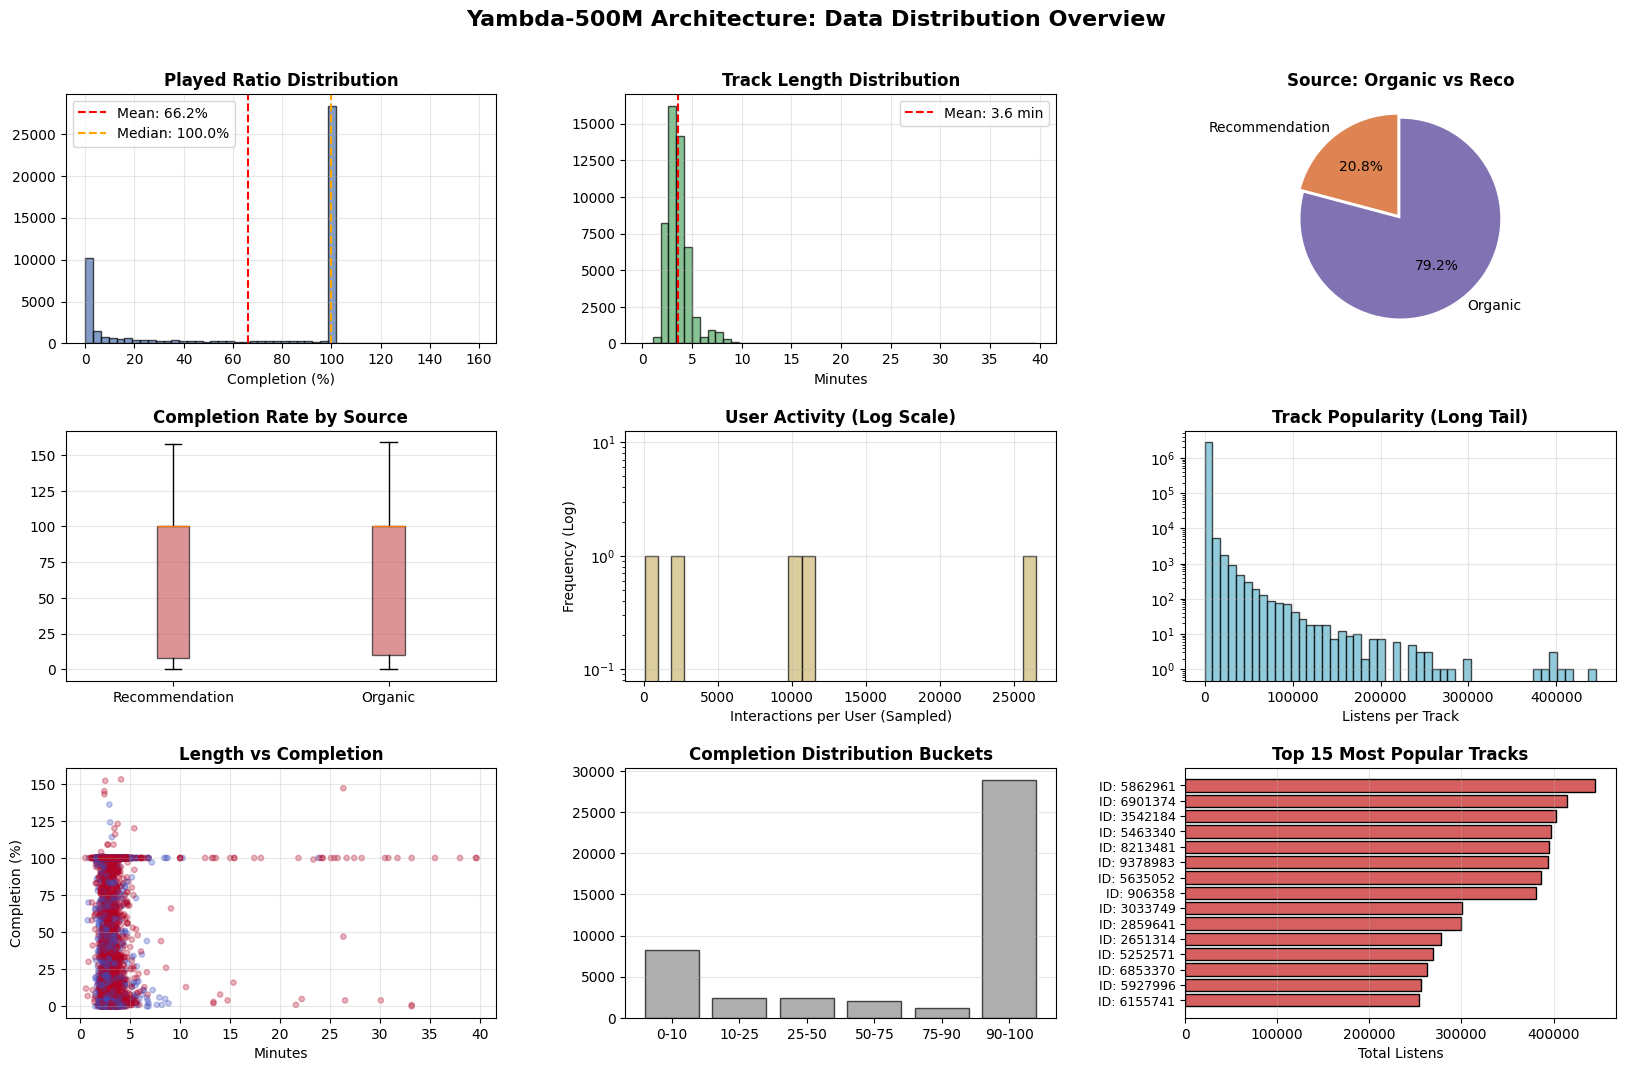

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n6. GENERATING VISUALIZATIONS (ARCHITECTURAL TIER)")
print("-" * 80)

# --- 1. INTELLIGENT DATA FETCHING ---
# Chúng ta cần 3 luồng dữ liệu:
# A. Dữ liệu thô (Raw) để xem phân phối played_ratio, track_length
# B. Dữ liệu Track (Aggregated) để xem track popularity (Đã có từ Bước 4: df_tracks)
# C. Dữ liệu User (Aggregated) để xem user activity

print("📥 Fetching visual samples from Lazy Engine...")

# Query A: Raw Sample (Lấy 50k dòng đầu tiên đại diện cho phân phối chung)
# .fetch(n) trên LazyFrame thường nhanh hơn .head().collect()
q_raw_sample = df_lazy.select([
    "uid", "item_id", "played_ratio_pct",
    "track_length_seconds", "is_organic"
]).head(50_000)

# Query C: User Activity Proxy
# Vì ta chưa tính user_stats full (rất nặng), ta sẽ tính sơ bộ trên mẫu 50k dòng
# để lấy "dáng" phân phối (Distribution Shape) thay vì tính chính xác 500M dòng.
# Điều này cực nhanh và đủ tốt cho biểu đồ Histogram.
# (Lưu ý: Query B không cần vì ta đã có biến df_tracks từ bước trước)

# Thực thi Lazy Query
raw_sample_pl = q_raw_sample.collect()
viz_sample = raw_sample_pl.to_pandas()

# Chuẩn bị dữ liệu Track từ kết quả Bước 4 (df_tracks đang nằm trên RAM)
# Chuyển sang Pandas chỉ các cột cần thiết để vẽ (nhẹ)
if 'df_tracks' in locals():
    track_pop_series = df_tracks.select("n_listens").to_pandas()['n_listens']
    # Lấy top 15 track (đã sort sẵn hoặc sort lại rất nhanh trên 2.7M dòng)
    top_tracks = df_tracks.top_k(15, by="n_listens").to_pandas()
else:
    # Fallback nếu chưa chạy bước 4 (Chỉ để demo an toàn)
    print("⚠️ Warning: df_tracks not found. Using raw sample approximation.")
    track_pop_series = viz_sample['item_id'].value_counts()
    top_tracks = pd.DataFrame({'item_id': [0], 'n_listens': [0]})

# User Activity Approximation (Tính trên mẫu raw)
user_activity_sample = viz_sample['uid'].value_counts()

print(f"✅ Data ready. Raw Sample: {len(viz_sample):,} rows. Track Stats: Available.")

# --- 2. PLOTTING PHASE (Matplotlib Vectorized) ---
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Tính toán các chỉ số thống kê cục bộ cho visual
played_mean = viz_sample['played_ratio_pct'].mean()
played_median = viz_sample['played_ratio_pct'].median()
track_len_min_mean = viz_sample['track_length_seconds'].mean() / 60

# 1. Played Ratio Distribution
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(viz_sample['played_ratio_pct'], bins=50, edgecolor='black', color='#4C72B0', alpha=0.7)
ax1.axvline(played_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {played_mean:.1f}%')
ax1.axvline(played_median, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {played_median:.1f}%')
ax1.set_title('Played Ratio Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Completion (%)')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Track Length Distribution
ax2 = fig.add_subplot(gs[0, 1])
track_lens_min = viz_sample['track_length_seconds'] / 60
ax2.hist(track_lens_min, bins=50, edgecolor='black', color='#55A868', alpha=0.7)
ax2.axvline(track_len_min_mean, color='red', linestyle='--', label=f'Mean: {track_len_min_mean:.1f} min')
ax2.set_title('Track Length Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Minutes')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Organic vs Recommendation
ax3 = fig.add_subplot(gs[0, 2])
organic_counts = viz_sample['is_organic'].value_counts()
labels = ['Recommendation', 'Organic']
# Map 0->Recommendation, 1->Organic. Handle missing keys safely.
sizes = [organic_counts.get(0, 0), organic_counts.get(1, 0)]
ax3.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#DD8452', '#8172B3'], startangle=90, explode=(0.05, 0))
ax3.set_title('Source: Organic vs Reco', fontsize=12, fontweight='bold')

# 4. Completion Rate by Source (Boxplot)
ax4 = fig.add_subplot(gs[1, 0])
# Prepare data list for boxplot
data_reco = viz_sample[viz_sample['is_organic'] == 0]['played_ratio_pct']
data_org = viz_sample[viz_sample['is_organic'] == 1]['played_ratio_pct']
ax4.boxplot([data_reco, data_org], labels=['Recommendation', 'Organic'], patch_artist=True,
            boxprops=dict(facecolor="#C44E52", alpha=0.6))
ax4.set_title('Completion Rate by Source', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3, axis='y')

# 5. User Activity (Log Scale)
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(user_activity_sample, bins=30, edgecolor='black', color='#CCB974', alpha=0.7)
ax5.set_yscale('log')
ax5.set_title('User Activity (Log Scale)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Interactions per User (Sampled)')
ax5.set_ylabel('Frequency (Log)')
ax5.grid(alpha=0.3)

# 6. Track Popularity (Log Scale) - Dữ liệu thật từ Step 4
ax6 = fig.add_subplot(gs[1, 2])
ax6.hist(track_pop_series, bins=50, edgecolor='black', color='#64B5CD', alpha=0.7)
ax6.set_yscale('log')
ax6.set_title('Track Popularity (Long Tail)', fontsize=12, fontweight='bold')
ax6.set_xlabel('Listens per Track')
ax6.grid(alpha=0.3)

# 7. Scatter: Length vs Completion
ax7 = fig.add_subplot(gs[2, 0])
# Downsample scatter further to 5000 points to avoid rendering lag
scatter_data = viz_sample.iloc[:5000]
sc = ax7.scatter(scatter_data['track_length_seconds']/60,
           scatter_data['played_ratio_pct'],
           c=scatter_data['is_organic'], cmap='coolwarm', alpha=0.3, s=15)
ax7.set_title('Length vs Completion', fontsize=12, fontweight='bold')
ax7.set_xlabel('Minutes')
ax7.set_ylabel('Completion (%)')
ax7.grid(alpha=0.3)

# 8. Completion Bins
ax8 = fig.add_subplot(gs[2, 1])
bins = [0, 10, 25, 50, 75, 90, 100]
labels_bins = ['0-10', '10-25', '25-50', '50-75', '75-90', '90-100']
binned_data = pd.cut(viz_sample['played_ratio_pct'], bins=bins, labels=labels_bins)
binned_counts = binned_data.value_counts().sort_index()
ax8.bar(labels_bins, binned_counts, color='#8C8C8C', edgecolor='black', alpha=0.7)
ax8.set_title('Completion Distribution Buckets', fontsize=12, fontweight='bold')
ax8.grid(alpha=0.3, axis='y')

# 9. Top 15 Tracks
ax9 = fig.add_subplot(gs[2, 2])
# Đảo ngược để bài top 1 nằm trên cùng
y_pos = np.arange(len(top_tracks))
ax9.barh(y_pos, top_tracks['n_listens'], align='center', color='#D65F5F', edgecolor='black')
ax9.set_yticks(y_pos)
# Label: Track ID
ax9.set_yticklabels([f'ID: {i}' for i in top_tracks['item_id']], fontsize=9)
ax9.invert_yaxis()
ax9.set_xlabel('Total Listens')
ax9.set_title('Top 15 Most Popular Tracks', fontsize=12, fontweight='bold')
ax9.grid(alpha=0.3, axis='x')

plt.suptitle('Yambda-500M Architecture: Data Distribution Overview', fontsize=16, fontweight='bold', y=0.95)


# --- ROBUST SAVING STRATEGY ---
# Định nghĩa đường dẫn ưu tiên (Drive) và dự phòng (Local)
drive_path = '/content/drive/MyDrive/yambda_eda_optimized.png'
local_path = '/content/yambda_eda_optimized.png' # Lưu ngay tại thư mục hiện tại của Colab

print("\n💾 Saving Plot...")

try:
    # Thử lưu vào Drive
    plt.savefig(drive_path, dpi=150, bbox_inches='tight')
    print(f"✅ Success! Visualization saved to Google Drive: {drive_path}")

except (FileNotFoundError, OSError):
    # Nếu lỗi (do chưa mount Drive), tự động chuyển sang lưu Local
    print(f"⚠️ Google Drive path not found (Drive not mounted).")
    print(f"🔄 Fallback strategy triggered: Saving locally...")

    plt.savefig(local_path, dpi=150, bbox_inches='tight')
    print(f"✅ Success! Saved to local runtime: {os.path.abspath(local_path)}")
    print("👉 ACTION: Look at the 'Files' icon (left sidebar) -> Refresh -> Download the image.")

plt.show()

In [ ]:
import polars as pl

print("\n5. TEMPORAL PATTERNS (FULL DATASET SCAN)")
print("-" * 80)

# ---------------------------------------------------------
# BƯỚC 1: LOGIC BIẾN ĐỔI (LAZY)
# ---------------------------------------------------------
# Thay vì sample, ta xử lý toàn bộ 500M dòng.
# Polars đủ sức làm việc này trong vài chục giây nếu chỉ đọc 3 cột.

temporal_lazy = (
    df_lazy
    # 1. Projection Pushdown: Chỉ đọc đúng 3 cột cần thiết từ đĩa/RAM
    .select(["timestamp", "is_organic", "played_ratio_pct"])

    # 2. Tính toán Hour Bin ngay trên Lazy Frame
    # Ép kiểu về UInt32 (hoặc UInt16) để tiết kiệm RAM tối đa khi GroupBy
    # (Giả sử công thức của bạn: timestamp * 5 giây / 3600 giây = giờ)
    .with_columns([
        ((pl.col("timestamp") * 5) / 3600).cast(pl.UInt32).alias("hour_bin")
    ])
)

# ---------------------------------------------------------
# BƯỚC 2: AGGREGATION (STREAMING)
# ---------------------------------------------------------
# GroupBy trên 500M dòng nhưng kết quả trả về chỉ có vài nghìn dòng (số giờ)
# Streaming=True xử lý việc này nhẹ nhàng mà không cần Sample.

print("⏳ Aggregating temporal trends on FULL dataset (Streaming)...")

hourly_stats = (
    temporal_lazy
    .group_by("hour_bin")
    .agg([
        pl.len().alias("n_interactions"), # Nhanh hơn count()
        # Cast Float32 để giảm RAM cho bảng kết quả
        pl.col("is_organic").mean().cast(pl.Float32).alias("organic_ratio"),
        pl.col("played_ratio_pct").mean().cast(pl.Float32).alias("avg_completion"),
    ])
    .collect(streaming=True) # Kích hoạt Streaming Engine
    .sort("hour_bin")
)

# ---------------------------------------------------------
# REPORTING
# ---------------------------------------------------------
total_interactions = hourly_stats["n_interactions"].sum()
n_hours = len(hourly_stats)

# Tìm giờ cao điểm (Peak Hour)
peak_hour_row = hourly_stats.sort("n_interactions", descending=True).row(0)
peak_hour = peak_hour_row[0]
peak_vol = peak_hour_row[1]

print(f"Analyzed: {total_interactions:,} interactions (100% Data Coverage)")
print(f"Time span: {n_hours} hours (approx {n_hours/24:.1f} days)")
print(f"Peak Activity Hour: Bin {peak_hour} with {peak_vol:,} interactions")

# Preview data
print("\nFirst 5 hours of data:")
print(hourly_stats.head(5))


5. TEMPORAL PATTERNS (FULL DATASET SCAN)
--------------------------------------------------------------------------------
⏳ Aggregating temporal trends on FULL dataset (Streaming)...


/tmp/ipython-input-1675159494.py:42: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True) # Kích hoạt Streaming Engine


Analyzed: 466,512,103 interactions (100% Data Coverage)
Time span: 36112 hours (approx 1504.7 days)
Peak Activity Hour: Bin 34514 with 31,910 interactions

First 5 hours of data:
shape: (5, 4)
┌──────────┬────────────────┬───────────────┬────────────────┐
│ hour_bin ┆ n_interactions ┆ organic_ratio ┆ avg_completion │
│ ---      ┆ ---            ┆ ---           ┆ ---            │
│ u32      ┆ u32            ┆ f32           ┆ f32            │
╞══════════╪════════════════╪═══════════════╪════════════════╡
│ 0        ┆ 2648           ┆ 0.566088      ┆ 67.691467      │
│ 1        ┆ 2527           ┆ 0.552829      ┆ 64.592796      │
│ 2        ┆ 2382           ┆ 0.56927       ┆ 62.479851      │
│ 3        ┆ 2225           ┆ 0.560449      ┆ 67.355507      │
│ 4        ┆ 2491           ┆ 0.560417      ┆ 64.97551       │
└──────────┴────────────────┴───────────────┴────────────────┘


In [ ]:
print("\n7. ENGAGEMENT PATTERN ANALYSIS")
print("-" * 80)

# Tối ưu: Sử dụng cut() thay vì nhiều when/then, và tính toán một lần
engagement_analysis = (
    df_lazy
    .select([
        pl.col("played_ratio_pct")
          .cut(
              breaks=[10, 50, 100],
              labels=["skip", "partial", "most", "full"]
          )
          .alias("engagement_level"),
        pl.col("is_organic")
    ])
    .group_by(["engagement_level", "is_organic"])
    .agg(pl.len().alias("count"))  # pl.len() nhanh hơn pl.count()
    .sort(["engagement_level", "is_organic"])  # Sắp xếp trong query plan
    .collect(streaming=True)
)

print("\n📊 Engagement Levels:")

# Tối ưu: Dùng to_dicts() một lần thay vì iter_rows()
source_map = {True: "Organic", False: "Recommendation"}
for row in engagement_analysis.to_dicts():
    print(f"   {row['engagement_level'].capitalize():8} ({source_map[row['is_organic']]:14}): {row['count']:>10,}")


7. ENGAGEMENT PATTERN ANALYSIS
--------------------------------------------------------------------------------


/tmp/ipython-input-3762048475.py:19: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)



📊 Engagement Levels:
   Skip     (Recommendation): 50,978,806
   Skip     (Organic       ): 75,957,258
   Partial  (Recommendation): 20,784,595
   Partial  (Organic       ): 24,494,581
   Most     (Recommendation): 154,443,417
   Most     (Organic       ): 137,756,181
   Full     (Recommendation):    577,495
   Full     (Organic       ):  1,519,770


In [ ]:
print("\n8. DATA QUALITY CHECK")
print("-" * 80)

# Key optimizations:
# 1. Cast boolean → UInt8 TRƯỚC khi aggregate (streaming-friendly)
# 2. Tránh .is_null() chain — dùng .null_count() cho null checks
# 3. Combine predicates trên cùng column để reduce scan passes

quality_check = (
    df_lazy
    .select([
        # Null counts — null_count() efficient hơn is_null().sum()
        pl.col("uid").null_count().alias("null_uid"),
        pl.col("item_id").null_count().alias("null_item_id"),
        pl.col("timestamp").null_count().alias("null_timestamp"),
        pl.col("played_ratio_pct").null_count().alias("null_played_ratio"),

        # Anomaly predicates — cast để streaming accumulator hiệu quả
        (pl.col("played_ratio_pct") > 200).sum().alias("very_high_played_ratio"),

        # Combine conditions trên cùng column
        (pl.col("track_length_seconds") == 0).sum().alias("zero_length_tracks"),
        (pl.col("track_length_seconds") > 3600).sum().alias("very_long_tracks"),
    ])
    .collect(
        streaming=True,
        # Polars 1.x: có thể tune chunk size nếu cần
        # comm_subplan_elim=True,  # Default True, giữ nguyên
    )
)

# Output formatting — không đổi logic
print("Null values:")
print(f"   uid: {quality_check['null_uid'][0]:,}")
print(f"   item_id: {quality_check['null_item_id'][0]:,}")
print(f"   timestamp: {quality_check['null_timestamp'][0]:,}")
print(f"   played_ratio_pct: {quality_check['null_played_ratio'][0]:,}")
print("\nData anomalies:")
print(f"   Played ratio >200%: {quality_check['very_high_played_ratio'][0]:,}")
print(f"   Zero-length tracks: {quality_check['zero_length_tracks'][0]:,}")
print(f"   Very long tracks (>1h): {quality_check['very_long_tracks'][0]:,}")


8. DATA QUALITY CHECK
--------------------------------------------------------------------------------


/tmp/ipython-input-2298767759.py:25: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(


Null values:
   uid: 0
   item_id: 0
   timestamp: 0
   played_ratio_pct: 0

Data anomalies:
   Played ratio >200%: 0
   Zero-length tracks: 0
   Very long tracks (>1h): 0


In [ ]:
# Pass 1: Scalar aggregations (streamable)
scalar_stats = (
    df_lazy
    .select([
        pl.len().alias("n_rows"),
        pl.col("played_ratio_pct").mean().alias("avg_played_ratio"),
        pl.col("played_ratio_pct").median().alias("median_played_ratio"),
        (pl.col("played_ratio_pct") >= 100).sum().alias("full_completions"),
        (pl.col("played_ratio_pct") < 10).sum().alias("skips"),
        pl.col("track_length_seconds").mean().alias("avg_track_length"),
        # Organic — adjust to your schema
        pl.col("is_organic").mean().alias("organic_ratio"),
    ])
    .collect(streaming=True)
)

# Pass 2: Cardinality + per-entity averages
# n_unique() cần full materialization, không có cách khác cho exact count
cardinality_stats = (
    df_lazy
    .select([
        pl.col("uid").n_unique().alias("unique_users"),
        pl.col("item_id").n_unique().alias("unique_items"),
    ])
    .collect(streaming=True)
)

# Derived metrics — pure Python, instant
n_rows = scalar_stats["n_rows"][0]
unique_users = cardinality_stats["unique_users"][0]
unique_items = cardinality_stats["unique_items"][0]

summary_dict = {
    "Metric": [
        "Total Interactions",
        "Unique Users",
        "Unique Tracks",
        "Avg Interactions/User",
        "Avg Listens/Track",
        "Organic Ratio",
        "Avg Played Ratio",
        "Median Played Ratio",
        "Full Completion Rate",
        "Skip Rate (<10%)",
        "Avg Track Length (min)",
    ],
    "Value": [
        f"{n_rows:,}",
        f"{unique_users:,}",
        f"{unique_items:,}",
        f"{n_rows / unique_users:.1f}",
        f"{n_rows / unique_items:.1f}",
        f"{scalar_stats['organic_ratio'][0] * 100:.2f}%",
        f"{scalar_stats['avg_played_ratio'][0]:.2f}%",
        f"{scalar_stats['median_played_ratio'][0]:.2f}%",
        f"{scalar_stats['full_completions'][0] / n_rows * 100:.2f}%",
        f"{scalar_stats['skips'][0] / n_rows * 100:.2f}%",
        f"{scalar_stats['avg_track_length'][0] / 60:.2f}",
    ],
}

# Output
summary_df = pl.DataFrame(summary_dict)  # Dùng Polars, không cần pandas
print(summary_df)

# Save — Polars native I/O nhanh hơn pandas
summary_df.write_csv("/content/yambda_summary.csv")
print("\n✅ Summary saved to Google Drive")

/tmp/ipython-input-2806876736.py:14: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)
/tmp/ipython-input-2806876736.py:25: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


shape: (11, 2)
┌────────────────────────┬─────────────┐
│ Metric                 ┆ Value       │
│ ---                    ┆ ---         │
│ str                    ┆ str         │
╞════════════════════════╪═════════════╡
│ Total Interactions     ┆ 466,512,103 │
│ Unique Users           ┆ 92,085      │
│ Unique Tracks          ┆ 2,796,658   │
│ Avg Interactions/User  ┆ 5066.1      │
│ Avg Listens/Track      ┆ 166.8       │
│ …                      ┆ …           │
│ Avg Played Ratio       ┆ 64.65%      │
│ Median Played Ratio    ┆ 100.00%     │
│ Full Completion Rate   ┆ 53.52%      │
│ Skip Rate (<10%)       ┆ 26.68%      │
│ Avg Track Length (min) ┆ 3.45        │
└────────────────────────┴─────────────┘

✅ Summary saved to Google Drive


In [ ]:
print("\n10. PERFORMANCE METRICS")
print("-" * 80)
import time
from contextlib import contextmanager

@contextmanager
def timer(name: str):
    """Context manager cho consistent timing."""
    start = time.perf_counter()  # perf_counter > time.time cho benchmarks
    yield
    elapsed = time.perf_counter() - start
    print(f"   {name}: {elapsed:.4f}s")

def benchmark(fn, name: str, warmup: int = 1, runs: int = 3):
    """Run với warmup và multiple iterations."""
    # Warmup — prime caches
    for _ in range(warmup):
        fn()

    # Timed runs
    times = []
    for _ in range(runs):
        start = time.perf_counter()
        fn()
        times.append(time.perf_counter() - start)

    avg = sum(times) / len(times)
    min_t = min(times)
    print(f"   {name}: {avg:.4f}s avg, {min_t:.4f}s best (n={runs})")

print("\n⏱️  Performance Benchmarks:")

# Reuse single LazyFrame — fair comparison
lazy_df = pl.scan_parquet(local_file_path)

# 1. Count — baseline
benchmark(
    lambda: lazy_df.select(pl.len()).collect(streaming=True),
    "Count (streaming)"
)

# 2. Single aggregation
benchmark(
    lambda: lazy_df.select(pl.col("played_ratio_pct").mean()).collect(streaming=True),
    "Mean (single column)"
)

# 3. Multiple aggregations — the one you care about
benchmark(
    lambda: lazy_df.select([
        pl.col("played_ratio_pct").mean(),
        pl.col("uid").n_unique(),
    ]).collect(streaming=True),
    "Aggregation (mean + n_unique)"
)

# 4. Group by — compare streaming vs non-streaming
benchmark(
    lambda: lazy_df.group_by("is_organic").agg(pl.len()).collect(streaming=True),
    "Group by (streaming)"
)

benchmark(
    lambda: lazy_df.group_by("is_organic").agg(pl.len()).collect(streaming=False),
    "Group by (non-streaming)"
)

# 5. Reality check — actual query plan
print("\n📋 Query Plan Analysis:")
print(
    lazy_df
    .select([
        pl.col("played_ratio_pct").mean(),
        pl.col("uid").n_unique(),
    ])
    .explain(streaming=True)
)


10. PERFORMANCE METRICS
--------------------------------------------------------------------------------

⏱️  Performance Benchmarks:
   Count (streaming): 0.0115s avg, 0.0109s best (n=3)


/tmp/ipython-input-3288218263.py:38: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  lambda: lazy_df.select(pl.len()).collect(streaming=True),
/tmp/ipython-input-3288218263.py:44: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  lambda: lazy_df.select(pl.col("played_ratio_pct").mean()).collect(streaming=True),


   Mean (single column): 1.1595s avg, 0.8741s best (n=3)


/tmp/ipython-input-3288218263.py:53: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ]).collect(streaming=True),


   Aggregation (mean + n_unique): 4.0730s avg, 3.7248s best (n=3)


/tmp/ipython-input-3288218263.py:59: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  lambda: lazy_df.group_by("is_organic").agg(pl.len()).collect(streaming=True),


   Group by (streaming): 3.6448s avg, 3.2701s best (n=3)


/tmp/ipython-input-3288218263.py:64: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  lambda: lazy_df.group_by("is_organic").agg(pl.len()).collect(streaming=False),


   Group by (non-streaming): 3.7287s avg, 3.3434s best (n=3)

📋 Query Plan Analysis:
SELECT [col("played_ratio_pct").mean(), col("uid").n_unique()]
  Parquet SCAN [/content/temp_data/flat/500m/listens.parquet] [id: 139931452243984]
  PROJECT 2/6 COLUMNS


/tmp/ipython-input-3288218263.py:76: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .explain(streaming=True)


In [ ]:
print("🎵 LOADING MUSIC-RELATED DATA")
print("=" * 80)

from huggingface_hub import hf_hub_download
import polars as pl
from pathlib import Path

# Target directory
output_dir = Path("/content/yambda_data")
output_dir.mkdir(exist_ok=True)

# Files to download
files = [
    ("embeddings.parquet", "audio embeddings"),
    ("artist_item_mapping.parquet", "artist-item mapping"),
    ("album_item_mapping.parquet", "album-item mapping"),
]

dataframes = {}

for filename, description in files:
    print(f"\n📥 Downloading {description}...")

    # Download trực tiếp từ HF Hub → local path
    local_path = hf_hub_download(
        repo_id="yandex/yambda",
        filename=filename,
        repo_type="dataset",
        local_dir=output_dir,
        local_dir_use_symlinks=False,  # Copy thật, không symlink
    )

    # Load với Polars để verify + get row count
    df = pl.scan_parquet(local_path)
    row_count = df.select(pl.len()).collect().item()

    print(f"✅ {description}: {row_count:,} rows")
    print(f"   📁 Saved to: {local_path}")

    # Store reference
    dataframes[filename.replace(".parquet", "")] = local_path

print("\n" + "=" * 80)
print("✅ All files downloaded to:", output_dir)
print("\nFile paths:")
for name, path in dataframes.items():
    print(f"   {name}: {path}")

🎵 LOADING MUSIC-RELATED DATA

📥 Downloading audio embeddings...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


embeddings.parquet:   0%|          | 0.00/13.8G [00:00<?, ?B/s]

✅ audio embeddings: 7,721,749 rows
   📁 Saved to: /content/yambda_data/embeddings.parquet

📥 Downloading artist-item mapping...


artist_item_mapping.parquet:   0%|          | 0.00/38.3M [00:00<?, ?B/s]

✅ artist-item mapping: 9,271,906 rows
   📁 Saved to: /content/yambda_data/artist_item_mapping.parquet

📥 Downloading album-item mapping...


album_item_mapping.parquet:   0%|          | 0.00/54.5M [00:00<?, ?B/s]

✅ album-item mapping: 9,651,644 rows
   📁 Saved to: /content/yambda_data/album_item_mapping.parquet

✅ All files downloaded to: /content/yambda_data

File paths:
   embeddings: /content/yambda_data/embeddings.parquet
   artist_item_mapping: /content/yambda_data/artist_item_mapping.parquet
   album_item_mapping: /content/yambda_data/album_item_mapping.parquet


In [ ]:
# ===================================================================
# CELL KHÁM PHÁ DỮ LIỆU (DEBUGGING CELL)
# ===================================================================
# Giả định rằng bạn đã chạy xong bước sink và có đường dẫn `filtered_emb_path`
# Nếu chạy độc lập, hãy thay thế bằng đường dẫn thật đến file embedding của bạn
# filtered_emb_path = "/content/yambda_data/embeddings.parquet" #- Ví dụ

print("🕵️  KHÁM PHÁ CẤU TRÚC FILE EMBEDDING\n" + "="*40)

# Sử dụng scan để không tốn RAM
emb_scan = pl.scan_parquet("/content/yambda_data/embeddings.parquet")

# 1. In ra Schema: Đây là bước quan trọng nhất
# Nó sẽ cho chúng ta biết tên cột và kiểu dữ liệu chính xác
print("\n[1] Schema của file Parquet:")
schema = emb_scan.collect_schema()
print(schema)


🕵️  KHÁM PHÁ CẤU TRÚC FILE EMBEDDING

[1] Schema của file Parquet:
Schema({'item_id': UInt32, 'embed': List(Float64), 'normalized_embed': List(Float64)})


In [ ]:
from dataclasses import dataclass, field
from typing import Optional, Any, Dict, List, Tuple, Union
import numpy as np

@dataclass
class GlobalStatistics:
    """
    Thống kê toàn cục của embedding vectors.

    Attributes:
        n_samples: Số lượng vectors đã phân tích
        n_dimensions: Số chiều của embeddings

        # === THỐNG KÊ CƠ BẢN ===
        global_mean: Trung bình của tất cả các giá trị trong embeddings
        global_std: Độ lệch chuẩn trung bình qua các chiều
        global_min: Giá trị nhỏ nhất trong toàn bộ embeddings
        global_max: Giá trị lớn nhất trong toàn bộ embeddings

        # === THỐNG KÊ THEO CHIỀU ===
        per_dim_mean: Vector trung bình theo từng chiều (n_dimensions,)
        per_dim_std: Vector độ lệch chuẩn theo từng chiều (n_dimensions,)

        # === CHẤT LƯỢNG DỮ LIỆU ===
        zero_vectors_count: Số lượng vectors toàn số 0
        zero_vectors_pct: Phần trăm vectors toàn số 0

        # === METADATA ===
        total_filtered_rows: Tổng số rows sau filtering
        execution_time_sec: Thời gian thực thi (giây)
        metadata: Thông tin bổ sung
    """

    # === KÍCH THƯỚC DỮ LIỆU ===
    n_samples: int = 0
    n_dimensions: int = 0
    total_filtered_rows: int = 0

    # === THỐNG KÊ CƠ BẢN ===
    global_mean: float = 0.0
    global_std: float = 0.0
    global_min: float = 0.0
    global_max: float = 0.0

    # === THỐNG KÊ THEO CHIỀU ===
    per_dim_mean: Optional[np.ndarray] = None
    per_dim_std: Optional[np.ndarray] = None

    # === CHẤT LƯỢNG DỮ LIỆU ===
    zero_vectors_count: int = 0
    zero_vectors_pct: float = 0.0

    # === METADATA ===
    execution_time_sec: float = 0.0
    metadata: dict = field(default_factory=dict)

    def __post_init__(self):
        """Validate dữ liệu sau khi khởi tạo"""
        if self.per_dim_mean is not None and self.per_dim_std is not None:
            if len(self.per_dim_mean) != len(self.per_dim_std):
                raise ValueError(
                    f"Length mismatch: per_dim_mean ({len(self.per_dim_mean)}) "
                    f"!= per_dim_std ({len(self.per_dim_std)})"
                )
            if self.n_dimensions > 0 and len(self.per_dim_mean) != self.n_dimensions:
                raise ValueError(
                    f"per_dim_mean length ({len(self.per_dim_mean)}) "
                    f"!= n_dimensions ({self.n_dimensions})"
                )

    @property
    def is_valid(self) -> bool:
        """Kiểm tra xem thống kê có hợp lệ không"""
        return (
            self.n_samples > 0 and
            self.n_dimensions > 0 and
            self.per_dim_mean is not None and
            self.per_dim_std is not None
        )

    @property
    def sampling_rate(self) -> float:
        """Tỷ lệ sampling (nếu có)"""
        if self.total_filtered_rows == 0:
            return 0.0
        return self.n_samples / self.total_filtered_rows

    def get_dimension_summary(self, n_top: int = 5) -> dict:
        """
        Lấy thống kê của các chiều có độ lệch chuẩn cao/thấp nhất.

        Args:
            n_top: Số lượng chiều top cần lấy

        Returns:
            Dict chứa indices và values của các chiều extreme
        """
        if self.per_dim_std is None:
            return {}

        std_sorted_idx = np.argsort(self.per_dim_std)

        return {
            'lowest_variance_dims': {
                'indices': std_sorted_idx[:n_top].tolist(),
                'values': self.per_dim_std[std_sorted_idx[:n_top]].tolist()
            },
            'highest_variance_dims': {
                'indices': std_sorted_idx[-n_top:][::-1].tolist(),
                'values': self.per_dim_std[std_sorted_idx[-n_top:][::-1]].tolist()
            }
        }

    def summary(self) -> str:
        """Tạo báo cáo tóm tắt"""
        dim_summary = self.get_dimension_summary(n_top=3)

        summary_text = f"""
╔══════════════════════════════════════════════════════════════╗
║            GLOBAL EMBEDDING STATISTICS                       ║
╠══════════════════════════════════════════════════════════════╣
║ Total Filtered Rows:  {self.total_filtered_rows:>10,}                          ║
║ Samples Analyzed:     {self.n_samples:>10,}                          ║
║ Sampling Rate:        {self.sampling_rate:>9.2%}                          ║
║ Dimensions:           {self.n_dimensions:>10}                          ║
║                                                              ║
║ === GLOBAL STATISTICS ===                                   ║
║ Mean (global):        {self.global_mean:>10.6f}                          ║
║ Std (mean of dims):   {self.global_std:>10.6f}                          ║
║ Min Value:            {self.global_min:>10.6f}                          ║
║ Max Value:            {self.global_max:>10.6f}                          ║
║ Value Range:          {self.global_max - self.global_min:>10.6f}                          ║
║                                                              ║
║ === DATA QUALITY ===                                        ║
║ Zero Vectors:         {self.zero_vectors_count:>10,}                          ║
║ Zero Vectors %:       {self.zero_vectors_pct:>9.2%}                          ║
║                                                              ║
║ Execution Time:       {self.execution_time_sec:>10.2f}s                        ║
╚══════════════════════════════════════════════════════════════╝
"""

        if dim_summary:
            summary_text += "\n" + "="*64 + "\n"
            summary_text += "Top 3 Dimensions by Variance:\n"
            summary_text += "-" * 64 + "\n"

            summary_text += "Lowest Variance:\n"
            for idx, val in zip(dim_summary['lowest_variance_dims']['indices'],
                               dim_summary['lowest_variance_dims']['values']):
                summary_text += f"  Dim {idx:>4}: σ = {val:.6f}\n"

            summary_text += "\nHighest Variance:\n"
            for idx, val in zip(dim_summary['highest_variance_dims']['indices'],
                               dim_summary['highest_variance_dims']['values']):
                summary_text += f"  Dim {idx:>4}: σ = {val:.6f}\n"

        return summary_text.strip()

    def to_dict(self, include_arrays: bool = False) -> dict:
        """Export sang dictionary"""
        result = {
            'n_samples': self.n_samples,
            'n_dimensions': self.n_dimensions,
            'total_filtered_rows': self.total_filtered_rows,
            'sampling_rate': self.sampling_rate,
            'global_mean': self.global_mean,
            'global_std': self.global_std,
            'global_min': self.global_min,
            'global_max': self.global_max,
            'value_range': self.global_max - self.global_min,
            'zero_vectors_count': self.zero_vectors_count,
            'zero_vectors_pct': self.zero_vectors_pct,
            'execution_time_sec': self.execution_time_sec,
            'metadata': self.metadata,
        }

        if include_arrays and self.per_dim_mean is not None:
            result['per_dim_mean'] = self.per_dim_mean.tolist()
            result['per_dim_std'] = self.per_dim_std.tolist()

        # Add dimension summary
        result['dimension_summary'] = self.get_dimension_summary(n_top=5)

        return result

    def save(self, filepath: str | Path) -> None:
        """Lưu thống kê ra file"""
        import pickle
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)
        print(f"✓ Saved statistics to {filepath}")

    @classmethod
    def load(cls, filepath: str | Path) -> 'GlobalStatistics':
        """Load thống kê từ file"""
        import pickle
        with open(filepath, 'rb') as f:
            return pickle.load(f)

@dataclass
class AnalysisResults:
    """
    Một báo cáo toàn diện chứa kết quả từ quá trình phân tích embedding.
    """
    # === CÁC MODEL ĐÃ HUẤN LUYỆN ===
    ipca_model: Any = None
    kmeans_model: Any = None

    # === DỮ LIỆU DÙNG CHO EDA (trên sample) ===
    item_ids: Optional[np.ndarray] = None
    reduced_embeddings: Optional[np.ndarray] = None
    cluster_labels: Optional[np.ndarray] = None

    # === CÁC CHỈ SỐ CHẤT LƯỢNG MODEL ===
    pca_explained_variance_ratio: Optional[np.ndarray] = None
    kmeans_inertia: Optional[float] = None

    # === CÁC CHỈ SỐ CHẤT LƯỢNG EMBEDDING ===
    mean_similarity: float = 0.0
    pct_sim_gt_08: float = 0.0

    # === CHỈ SỐ HIỆU NĂNG ===
    execution_time_sec: float = 0.0

    # === METADATA (FIELD BỊ THIẾU) ===
    metadata: Dict[str, Any] = field(default_factory=dict)

    # === COMPUTED PROPERTIES ===
    @property
    def n_samples(self) -> int:
        if self.reduced_embeddings is not None:
            return self.reduced_embeddings.shape[0]
        return 0

    @property
    def n_components(self) -> int:
        if self.reduced_embeddings is not None:
            return self.reduced_embeddings.shape[1]
        return 0

    @property
    def n_clusters(self) -> int:
        if self.cluster_labels is not None:
            return len(np.unique(self.cluster_labels))
        return 0

    # === METHODS ===
    def is_complete(self) -> bool:
        """Kiểm tra analysis có hoàn thành không."""
        return (
            self.ipca_model is not None
            and self.kmeans_model is not None
            and self.reduced_embeddings is not None
            and self.cluster_labels is not None
            and 'error' not in self.metadata
        )

    def summary(self) -> str:
        """Tạo summary string."""
        lines = [
            "=" * 50,
            "ANALYSIS RESULTS SUMMARY",
            "=" * 50,
            f"Status: {'✅ Complete' if self.is_complete() else '⚠️ Incomplete'}",
            f"Samples: {self.n_samples:,}",
            f"PCA components: {self.n_components}",
            f"Clusters: {self.n_clusters}",
        ]
        if self.pca_explained_variance_ratio is not None:
            lines.append(f"Total explained variance: {np.sum(self.pca_explained_variance_ratio):.2%}")
        if self.kmeans_inertia is not None:
            lines.append(f"KMeans inertia: {self.kmeans_inertia:,.2f}")
        lines.append(f"Mean similarity: {self.mean_similarity:.6f}")
        lines.append(f"Pairs with sim > 0.8: {self.pct_sim_gt_08:.2f}%")
        lines.append(f"Execution time: {self.execution_time_sec:.2f}s")
        lines.append("=" * 50)
        return "\n".join(lines)

    def save(self, path: str):
        """Lưu results ra file pickle."""
        import pickle
        with open(path, 'wb') as f:
            pickle.dump(self, f)

    def to_dict(self) -> Dict[str, Any]:
        """Export metrics ra dict (không bao gồm large arrays)."""
        return {
            'n_samples': self.n_samples,
            'n_components': self.n_components,
            'n_clusters': self.n_clusters,
            'kmeans_inertia': self.kmeans_inertia,
            'mean_similarity': self.mean_similarity,
            'pct_sim_gt_08': self.pct_sim_gt_08,
            'execution_time_sec': self.execution_time_sec,
            'metadata': self.metadata,
        }

@dataclass
class Config:
    DATA_DIR: Path = Path("/content/yambda_data")
    INTERACTIONS: Path = Path("/content/temp_data/flat/500m/listens.parquet")
    EMBEDDINGS: Path = Path("/content/yambda_data/embeddings.parquet")
    ARTIST_MAP: Path = Path("/content/yambda_data/artist_item_mapping.parquet")
    ALBUM_MAP: Path = Path("/content/yambda_data/album_item_mapping.parquet")
    SAMPLE_SIZE: int = 80_000        # target sample for heavy math (will be min(total, SAMPLE_SIZE))
    CHUNK_SIZE: int = 10_000          # process this many rows per chunk (tuneable)
    PCA_COMPONENTS: int = 64         # reduced dims
    KMEANS_K: int = 15



In [ ]:
# Cell: GPU-first, OOM-proof compute_global_stats + run_heavy_math_on_sample
import polars as pl
import numpy as np
import tempfile
from pathlib import Path
import time
import gc
from dataclasses import dataclass

# Optional GPU libs (import lazily / gracefully)
_GPU_AVAILABLE = False
try:
    import cudf
    import cupy as cp
    from cuml.decomposition import IncrementalPCA as cuIncrementalPCA
    from cuml.cluster import KMeans as cuKMeans
    _GPU_AVAILABLE = True
except Exception:
    _GPU_AVAILABLE = False
    # We'll fallback to sklearn IncrementalPCA & MiniBatchKMeans if needed
    try:
        from sklearn.decomposition import IncrementalPCA as skIncrementalPCA
        from sklearn.cluster import MiniBatchKMeans as skMiniBatchKMeans
    except Exception:
        skIncrementalPCA = None
        skMiniBatchKMeans = None

# Helper: stack a polars DataFrame chunk that contains a List(Float*) column into 2D numpy
def _stack_list_col_to_numpy(pdf, list_col_name: str):
    """
    pdf: pandas DataFrame with one column `list_col_name` containing lists/ndarrays per row.
    returns: 2D numpy float32 array shape (n_rows, dim)
    """
    arrs = pdf[list_col_name].to_numpy()
    # arrs is an object array of lists -> stack
    mat = np.vstack(arrs).astype(np.float32)
    return mat

class TurboAnalyzer:
    def __init__(self, config: Config, valid_items_df: pl.DataFrame):
        self.config = config
        self.valid_df = valid_items_df
        self.emb_lf = None
        self.list_col = None  # name of embedding list column (e.g., 'normalized_embed')
        self.dim = None

    def setup(self):
        print("\n" + "="*60)
        print("STEP 3: EMBEDDING ANALYSIS (Hybrid GPU/CPU, OOM-proof)")
        print("="*60)
        if not Path(self.config.EMBEDDINGS).exists():
            print("❌ Embeddings file not found:", self.config.EMBEDDINGS)
            return False

        # discover schema and list column
        schema = pl.scan_parquet(self.config.EMBEDDINGS).collect_schema()
        # find a List column to use (prefer 'normalized_embed' then 'embed')
        possible = [c for c, t in zip(schema.names(), schema.dtypes()) if t.__class__.__name__ == "List"]
        chosen = None
        for cand in ("normalized_embed", "embed"):
            if cand in possible:
                chosen = cand; break
        if chosen is None:
            chosen = possible[0] if possible else None
        if chosen is None:
            print("❌ No List(Float) embedding column found in embeddings parquet.")
            return False

        self.list_col = chosen
        # detect dimension by peeking first few rows (very cheap)
        peek = (
            pl.scan_parquet(self.config.EMBEDDINGS)
            .select(pl.col(self.list_col).list.len())
            .fetch(1)
        )
        self.dim = int(peek[0,0])
        print(f"   Detected embedding column '{self.list_col}' with dim={self.dim}")
        # emb_lf filtered to valid items for downstream streaming
        self.emb_lf = (
            pl.scan_parquet(self.config.EMBEDDINGS)
            .join(self.valid_df.lazy(), on="item_id", how="semi")
            .select(["item_id", self.list_col])
        )
        print(f"   GPU available: {_GPU_AVAILABLE}")
        return True

    # ---------- streaming global stats (OOM-proof) -------------
    def compute_global_stats(self) -> GlobalStatistics:
      """
      Tính toán thống kê toàn cục của embeddings theo cách streaming, OOM-proof.

      Returns:
          GlobalStatistics: Đối tượng chứa đầy đủ thống kê toàn cục
      """
      print("\n" + "="*40)
      print("3.1 EMBEDDING GLOBAL STATISTICS (STREAMED, OOM-PROOF)")
      print("="*40)
      start = time.time()
      cfg = self.config

      # Sink filtered embeddings to temp parquet (streaming) - this is safe
      with tempfile.TemporaryDirectory() as td:
          filtered_path = Path(td) / "filtered_embeddings.parquet"
          print("   ⚙️ Sinking filtered embeddings to:", filtered_path)
          # streaming sink
          self.emb_lf.sink_parquet(filtered_path)

          # PASS 1: count rows
          total_rows = pl.scan_parquet(filtered_path).select(pl.count()).collect(streaming=True).row(0)[0]
          print(f"   🔢 Filtered rows: {total_rows:,}")

          # We will sample up to SAMPLE_SIZE rows uniformly by computing step
          sample_n = min(cfg.SAMPLE_SIZE, total_rows)

          if sample_n == 0:
              print("   ⚠️ No rows in filtered embeddings.")
              return GlobalStatistics(
                  total_filtered_rows=total_rows,
                  execution_time_sec=time.time() - start,
                  metadata={'error': 'no_rows_available'}
              )

          print(f"   🎯 Sampling target: {sample_n:,} rows")

          # We'll stream through the file in chunks and compute numerically-stable moments (Welford)
          # Use CPU numpy for moments to avoid CuPy availability issues; per-chunk stacking keeps memory bounded.
          count = 0
          mean = None
          m2 = None
          global_min = None
          global_max = None
          zero_vecs = 0
          n_dimensions = None

          # use reader: iterate with polars.fetch on partitions of CHUNK_SIZE
          scan = pl.scan_parquet(filtered_path).select(self.list_col)
          offset = 0
          while count < sample_n:
              need = min(cfg.CHUNK_SIZE, sample_n - count)
              # fetch next chunk (fetch supports offset by .slice)
              chunk_df = scan.slice(offset, need).fetch(need)
              offset += need
              # convert this chunk to pandas and stack list col -> numpy (bounded size)
              pdf = chunk_df.to_pandas()
              mat = _stack_list_col_to_numpy(pdf, self.list_col)   # float32

              # Get dimensions from first chunk
              if n_dimensions is None:
                  n_dimensions = mat.shape[1]

              # statistics update (Welford)
              if mean is None:
                  mean = np.mean(mat, axis=0).astype(np.float64)
                  m2 = np.var(mat, axis=0).astype(np.float64) * mat.shape[0]
              else:
                  # incremental combine
                  new_n = mat.shape[0]
                  new_mean = np.mean(mat, axis=0).astype(np.float64)
                  new_m2 = np.var(mat, axis=0).astype(np.float64) * new_n

                  delta = new_mean - mean
                  total_n = count + new_n
                  mean = (mean * count + new_mean * new_n) / total_n
                  m2 = m2 + new_m2 + (delta**2) * (count * new_n / total_n)

              local_min = mat.min()
              local_max = mat.max()
              global_min = local_min if global_min is None else min(global_min, local_min)
              global_max = local_max if global_max is None else max(global_max, local_max)
              zero_vecs += np.sum(np.all(mat == 0, axis=1))

              count += mat.shape[0]
              # free
              del mat, pdf
              gc.collect()

          # finalize
          var = (m2 / count).astype(np.float64)
          std = np.sqrt(var)
          g_mean = float(np.mean(mean))
          g_std = float(np.mean(std))

          print(f"   ✅ Sampled {count:,} vectors. Mean (global mean of dims): {g_mean:.6f}, Std (mean of per-dim std): {g_std:.6f}")
          print(f"   Global Min: {global_min:.6f}, Global Max: {global_max:.6f}")
          print(f"   Zero Vectors (in sample): {zero_vecs} ({zero_vecs/count:.2%})")
          print(f"   ⚡ Stats time: {time.time() - start:.2f}s")

          # Create and return GlobalStatistics
          stats = GlobalStatistics(
              # Kích thước
              n_samples=count,
              n_dimensions=n_dimensions or self.dim,
              total_filtered_rows=total_rows,

              # Thống kê cơ bản
              global_mean=g_mean,
              global_std=g_std,
              global_min=float(global_min) if global_min is not None else 0.0,
              global_max=float(global_max) if global_max is not None else 0.0,

              # Thống kê theo chiều
              per_dim_mean=mean.astype(np.float32) if mean is not None else None,
              per_dim_std=std.astype(np.float32) if std is not None else None,

              # Chất lượng dữ liệu
              zero_vectors_count=int(zero_vecs),
              zero_vectors_pct=float(zero_vecs / count) if count > 0 else 0.0,

              # Metadata
              execution_time_sec=time.time() - start,
              metadata={
                  'chunk_size': cfg.CHUNK_SIZE,
                  'sample_size_config': cfg.SAMPLE_SIZE,
                  'algorithm': 'welford_incremental',
                  'precision': 'float64_computation_float32_storage'
              }
          )

          # Print summary
          print("\n" + stats.summary())

          return stats

    # ---------- GPU-first heavy math, fully OOM-proof via chunking & incremental PCA -------------
    def run_heavy_math_on_sample(self) -> AnalysisResults:
      """
      Thực hiện phân tích toán học nâng cao trên sample embeddings.

      Returns:
          AnalysisResults: Đối tượng chứa đầy đủ kết quả phân tích
      """
      print("\n" + "="*40)
      print("3.2 EMBEDDING ADVANCED MATH (CHUNKED, GPU-FIRST, OOM-PROOF)")
      print("="*40)
      start_all = time.time()
      cfg = self.config

      # Sink filtered embeddings to temp parquet (streaming)
      with tempfile.TemporaryDirectory() as td:
          filtered_path = Path(td) / "filtered_embeddings.parquet"
          print("   ⚙️ Sinking filtered embeddings to:", filtered_path)
          self.emb_lf.sink_parquet(filtered_path)

          # Count rows
          total_rows = pl.scan_parquet(filtered_path).select(pl.count()).collect(streaming=True).row(0)[0]
          print(f"   🔢 Filtered rows: {total_rows:,}")
          sample_n = min(cfg.SAMPLE_SIZE, total_rows)

          if sample_n < 2:
              print("   ⚠️ Not enough samples for heavy math.")
              # Return empty results
              return AnalysisResults(
                  execution_time_sec=time.time() - start_all,
                  metadata={'error': 'insufficient_samples', 'total_rows': total_rows}
              )

          n_components = min(cfg.PCA_COMPONENTS, self.dim)

          # ---------- PASS 1: incremental PCA partial_fit over chunks ----------
          print(f"   📦 PASS 1: Incremental PCA partial_fit in chunks (n_components={n_components})")
          if _GPU_AVAILABLE:
              ipca = cuIncrementalPCA(n_components=n_components)
          else:
              if skIncrementalPCA is None:
                  raise RuntimeError("No IncrementalPCA available (install sklearn or RAPIDS).")
              ipca = skIncrementalPCA(n_components=n_components)

          # We'll sample uniformly across file by reading first sample_n rows only (slice)
          scan = pl.scan_parquet(filtered_path).select(self.list_col)
          processed = 0
          offset = 0
          while processed < sample_n:
              need = min(cfg.CHUNK_SIZE, sample_n - processed)
              chunk_df = scan.slice(offset, need).fetch(need)
              offset += need
              pdf = chunk_df.to_pandas()
              X_chunk = _stack_list_col_to_numpy(pdf, self.list_col)  # float32 numpy

              # move to GPU if possible
              if _GPU_AVAILABLE:
                  Xg = cp.asarray(X_chunk)   # small chunk -> OK
                  ipca.partial_fit(Xg)
                  del Xg
              else:
                  ipca.partial_fit(X_chunk)

              processed += X_chunk.shape[0]
              del X_chunk, pdf
              gc.collect()

          print(f"   ✅ Incremental PCA fitted over {processed:,} samples. Time so far: {time.time() - start_all:.2f}s")

          # ---------- PASS 2: transform & store reduced representations (memmap) ----------
          print("   📦 PASS 2: transform chunks -> write reduced reps to disk (memmap)")
          reduced_shape = (sample_n, n_components)
          memmap_path = Path(td) / "reduced_memmap.npy"
          reduced_mmap = np.memmap(memmap_path, mode='w+', dtype=np.float32, shape=reduced_shape)

          # Store item_ids as we process
          item_ids_list = []

          scan = pl.scan_parquet(filtered_path).select(["item_id", self.list_col])
          processed = 0
          offset = 0
          idx = 0
          while processed < sample_n:
              need = min(cfg.CHUNK_SIZE, sample_n - processed)
              chunk_df = scan.slice(offset, need).fetch(need)
              offset += need
              pdf = chunk_df.to_pandas()

              # Collect item_ids
              item_ids = pdf["item_id"].to_numpy()
              item_ids_list.append(item_ids)

              X_chunk = _stack_list_col_to_numpy(pdf, self.list_col)  # float32 numpy

              if _GPU_AVAILABLE:
                  Xg = cp.asarray(X_chunk)
                  Xred_g = ipca.transform(Xg)   # cupy array shape (batch, n_components)
                  Xred = cp.asnumpy(Xred_g).astype(np.float32)
                  del Xg, Xred_g
              else:
                  Xred = ipca.transform(X_chunk).astype(np.float32)

              # write into memmap at correct index
              reduced_mmap[idx: idx + Xred.shape[0], :] = Xred
              idx += Xred.shape[0]

              processed += X_chunk.shape[0]
              del X_chunk, pdf, Xred, item_ids
              gc.collect()

          # Combine all item_ids
          all_item_ids = np.concatenate(item_ids_list)

          # ensure flushed
          reduced_mmap.flush()
          del reduced_mmap
          gc.collect()
          print(f"   ✅ Reduced representations stored to memmap ({memmap_path}). Time so far: {time.time() - start_all:.2f}s")

          # ---------- PASS 3: KMeans on reduced data ----------
          print(f"   📦 PASS 3: KMeans (k={cfg.KMEANS_K}) on reduced data")
          # load full reduced array from memmap (this is small: sample_n * n_components)
          reduced_all = np.memmap(memmap_path, mode='r', dtype=np.float32, shape=reduced_shape)

          # Convert to regular array for return (copy to avoid memmap issues)
          reduced_embeddings_copy = np.asarray(reduced_all).copy()

          # if GPU available, move to GPU for cuML KMeans
          if _GPU_AVAILABLE:
              X_all_gpu = cp.asarray(np.asarray(reduced_all))
              kmeans = cuKMeans(n_clusters=cfg.KMEANS_K, random_state=42)
              kmeans.fit(X_all_gpu)
              cluster_labels = cp.asnumpy(kmeans.predict(X_all_gpu))
              inertia = float(kmeans.inertia_)
              del X_all_gpu
          else:
              # fallback to sklearn MiniBatchKMeans
              if skMiniBatchKMeans is None:
                  raise RuntimeError("No KMeans available (install scikit-learn or RAPIDS).")
              kmeans = skMiniBatchKMeans(n_clusters=cfg.KMEANS_K, batch_size=1024, random_state=42)
              kmeans.fit(np.asarray(reduced_all))
              cluster_labels = kmeans.predict(np.asarray(reduced_all))
              inertia = float(kmeans.inertia_)

          print(f"   ✅ KMeans done. Time so far: {time.time() - start_all:.2f}s")

          # ---------- PASS 4: similarity check (sampled pairs) ----------
          print("   📦 PASS 4: Similarity check on normalized reduced vectors (random pairs)")
          rng = np.random.default_rng(42)
          n_samples = reduced_shape[0]
          pair_n = min(20_000, max(1000, n_samples // 10))
          idx1 = rng.integers(0, n_samples, size=pair_n)
          idx2 = rng.integers(0, n_samples, size=pair_n)

          if _GPU_AVAILABLE:
              R = cp.asarray(np.asarray(reduced_all))  # move to GPU (small)
              # l2-normalize rows
              norms = cp.linalg.norm(R, axis=1)
              norms = cp.where(norms == 0, 1e-10, norms)
              Rn = R / norms[:, None]
              sims = cp.sum(Rn[idx1] * Rn[idx2], axis=1)
              mean_sim = float(cp.asnumpy(cp.mean(sims)))
              pct_over_08 = float(cp.asnumpy(cp.mean(sims > 0.8))) * 100.0
              del R, Rn, sims
          else:
              R = np.asarray(reduced_all)
              norms = np.linalg.norm(R, axis=1)
              norms[norms == 0] = 1e-10
              Rn = R / norms[:, None]
              sims = np.sum(Rn[idx1] * Rn[idx2], axis=1)
              mean_sim = float(np.mean(sims))
              pct_over_08 = float(np.mean(sims > 0.8)) * 100.0
              del R, Rn, sims

          print(f"   🔗 [Similarity Check] Mean Sim: {mean_sim:.6f} | Sim > 0.8: {pct_over_08:.2f}%")
          print(f"   ⚡ Total heavy math time: {time.time() - start_all:.2f}s")

          # Get PCA explained variance ratio
          if _GPU_AVAILABLE:
              # cuML's IncrementalPCA might store this differently
              explained_var = cp.asnumpy(ipca.explained_variance_ratio_) if hasattr(ipca, 'explained_variance_ratio_') else None
          else:
              explained_var = ipca.explained_variance_ratio_

          # Cleanup before returning
          del reduced_all
          gc.collect()

          # Create and return AnalysisResults
          results = AnalysisResults(
              # Models
              ipca_model=ipca,
              kmeans_model=kmeans,

              # Data for EDA
              item_ids=all_item_ids,
              reduced_embeddings=reduced_embeddings_copy,
              cluster_labels=cluster_labels,

              # Model quality metrics
              pca_explained_variance_ratio=explained_var,
              kmeans_inertia=inertia,

              # Embedding quality metrics
              mean_similarity=mean_sim,
              pct_sim_gt_08=pct_over_08,

              # Performance
              execution_time_sec=time.time() - start_all,

              # Metadata
              metadata={
                  'sample_size': sample_n,
                  'total_rows': total_rows,
                  'n_components': n_components,
                  'n_clusters': cfg.KMEANS_K,
                  'gpu_used': _GPU_AVAILABLE,
                  'chunk_size': cfg.CHUNK_SIZE,
                  'similarity_pairs_checked': pair_n
              }
          )

          # Print summary
          print("\n" + results.summary())

          return results



STEP 3: EMBEDDING ANALYSIS (Hybrid GPU/CPU, OOM-proof)


/tmp/ipython-input-2242638669.py:74: DeprecationWarning: `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  .fetch(1)


   Detected embedding column 'normalized_embed' with dim=128
   GPU available: True

3.1 EMBEDDING GLOBAL STATISTICS (STREAMED, OOM-PROOF)
   ⚙️ Sinking filtered embeddings to: /tmp/tmpyapkvzie/filtered_embeddings.parquet


/tmp/ipython-input-2242638669.py:109: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  total_rows = pl.scan_parquet(filtered_path).select(pl.count()).collect(streaming=True).row(0)[0]
/tmp/ipython-input-2242638669.py:109: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  total_rows = pl.scan_parquet(filtered_path).select(pl.count()).collect(streaming=True).row(0)[0]
/tmp/ipython-input-2242638669.py:141: DeprecationWarning: `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  chunk_df = scan.slice(offset, need).fetch(need)


   🔢 Filtered rows: 2,535,522
   🎯 Sampling target: 80,000 rows
   ✅ Sampled 80,000 vectors. Mean (global mean of dims): -0.002776, Std (mean of per-dim std): 0.081539
   Global Min: -0.412486, Global Max: 0.385893
   Zero Vectors (in sample): 0 (0.00%)
   ⚡ Stats time: 169.59s

╔══════════════════════════════════════════════════════════════╗
║            GLOBAL EMBEDDING STATISTICS                       ║
╠══════════════════════════════════════════════════════════════╣
║ Total Filtered Rows:   2,535,522                          ║
║ Samples Analyzed:         80,000                          ║
║ Sampling Rate:            3.16%                          ║
║ Dimensions:                  128                          ║
║                                                              ║
║ === GLOBAL STATISTICS ===                                   ║
║ Mean (global):         -0.002776                          ║
║ Std (mean of dims):     0.081539                          ║
║ Min Value:             

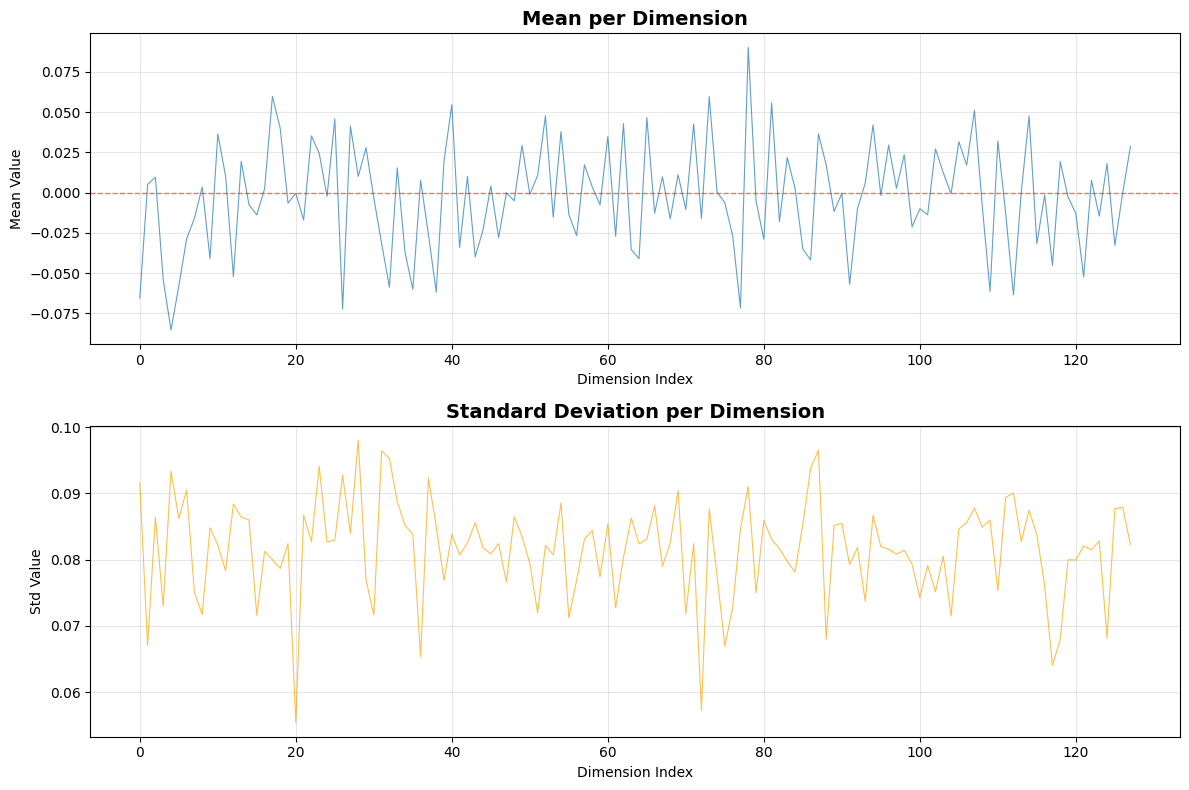

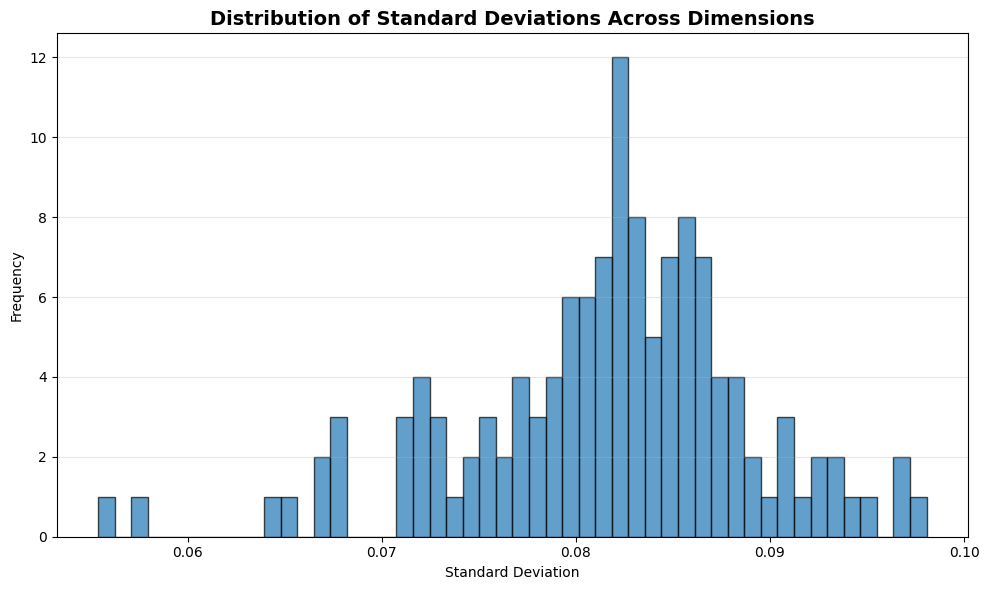


✅ Normalizer function created successfully!
   Ready to normalize vectors of dimension 128

🧪 Test normalization:
   Input shape: (10, 128)
   Output shape: (10, 128)
   Output mean: 0.426195
   Output std: 12.531339


In [ ]:
config = Config()
df_items = pl.scan_parquet(config.INTERACTIONS)

analyzer  = TurboAnalyzer(config, df_items)
analyzer.setup()

stats = analyzer.compute_global_stats()

# Check if valid
if stats.is_valid:
    print("✅ Statistics computed successfully!")

    # === ACCESS BASIC STATS ===
    print(f"\n📊 Basic Information:")
    print(f"  • Analyzed: {stats.n_samples:,} out of {stats.total_filtered_rows:,} vectors")
    print(f"  • Sampling rate: {stats.sampling_rate:.2%}")
    print(f"  • Dimensions: {stats.n_dimensions}")
    print(f"  • Global mean: {stats.global_mean:.6f}")
    print(f"  • Global std: {stats.global_std:.6f}")
    print(f"  • Value range: [{stats.global_min:.3f}, {stats.global_max:.3f}]")

    # === CHECK DATA QUALITY ===
    if stats.zero_vectors_pct > 0.01:  # More than 1% zero vectors
        print(f"\n⚠️  Warning: {stats.zero_vectors_pct:.2%} of vectors are all zeros!")

    # === ANALYZE DIMENSIONS ===
    dim_summary = stats.get_dimension_summary(n_top=10)
    print("\n📉 Dimensions with lowest variance:")
    for idx, val in zip(dim_summary['lowest_variance_dims']['indices'][:5],
                       dim_summary['lowest_variance_dims']['values'][:5]):
        print(f"  • Dimension {idx}: σ = {val:.6f}")

    print("\n📈 Dimensions with highest variance:")
    for idx, val in zip(dim_summary['highest_variance_dims']['indices'][:5],
                       dim_summary['highest_variance_dims']['values'][:5]):
        print(f"  • Dimension {idx}: σ = {val:.6f}")

    # === SAVE RESULTS ===
    stats.save("global_stats.pkl")

    # === EXPORT TO DICT ===
    stats_dict = stats.to_dict(include_arrays=False)
    print(f"\n💾 Exported {len(stats_dict)} keys to dictionary")

else:
    print("⚠️ Statistics invalid or incomplete")
    print(f"Metadata: {stats.metadata}")


# ============================================================================
# VISUALIZATION (optional - uncomment to use)
# ============================================================================

import matplotlib.pyplot as plt

if stats.is_valid and stats.per_dim_mean is not None:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Mean per dimension
    axes[0].plot(stats.per_dim_mean, linewidth=0.8, alpha=0.7)
    axes[0].set_title("Mean per Dimension", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("Dimension Index")
    axes[0].set_ylabel("Mean Value")
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5)

    # Std per dimension
    axes[1].plot(stats.per_dim_std, linewidth=0.8, alpha=0.7, color='orange')
    axes[1].set_title("Standard Deviation per Dimension", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Dimension Index")
    axes[1].set_ylabel("Std Value")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Additional plot: Distribution of std values
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.hist(stats.per_dim_std, bins=50, edgecolor='black', alpha=0.7)
    ax.set_title("Distribution of Standard Deviations Across Dimensions",
                 fontsize=14, fontweight='bold')
    ax.set_xlabel("Standard Deviation")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


# ============================================================================
# HOW TO USE STATISTICS FOR NORMALIZATION (when you have new data)
# ============================================================================

# Create a normalization function
def create_normalizer(stats: GlobalStatistics):
    """
    Create a normalization function from pre-computed statistics.

    Args:
        stats: GlobalStatistics object with per_dim_mean and per_dim_std

    Returns:
        Function that normalizes embeddings
    """
    if not stats.is_valid:
        raise ValueError("Statistics are not valid")

    def normalize(embeddings: np.ndarray) -> np.ndarray:
        """
        Standardize embeddings using pre-computed statistics.

        Args:
            embeddings: Array of shape (n_samples, n_dimensions)

        Returns:
            Normalized embeddings with same shape
        """
        if embeddings.shape[1] != stats.n_dimensions:
            raise ValueError(
                f"Expected {stats.n_dimensions} dimensions, "
                f"got {embeddings.shape[1]}"
            )
        return (embeddings - stats.per_dim_mean) / (stats.per_dim_std + 1e-8)

    return normalize

# Create the normalizer
if stats.is_valid:
    normalizer = create_normalizer(stats)
    print("\n✅ Normalizer function created successfully!")
    print(f"   Ready to normalize vectors of dimension {stats.n_dimensions}")

    # Test with random data
    test_embeddings = np.random.randn(10, stats.n_dimensions).astype(np.float32)
    normalized = normalizer(test_embeddings)
    print(f"\n🧪 Test normalization:")
    print(f"   Input shape: {test_embeddings.shape}")
    print(f"   Output shape: {normalized.shape}")
    print(f"   Output mean: {normalized.mean():.6f}")
    print(f"   Output std: {normalized.std():.6f}")


3.2 EMBEDDING ADVANCED MATH (CHUNKED, GPU-FIRST, OOM-PROOF)
   ⚙️ Sinking filtered embeddings to: /tmp/tmp6568pl6r/filtered_embeddings.parquet


/tmp/ipython-input-2242638669.py:245: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  total_rows = pl.scan_parquet(filtered_path).select(pl.count()).collect(streaming=True).row(0)[0]
/tmp/ipython-input-2242638669.py:245: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  total_rows = pl.scan_parquet(filtered_path).select(pl.count()).collect(streaming=True).row(0)[0]
/tmp/ipython-input-2242638669.py:274: DeprecationWarning: `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  chunk_df = scan.slice(offset, need).fetch(need)


   🔢 Filtered rows: 2,535,522
   📦 PASS 1: Incremental PCA partial_fit in chunks (n_components=64)
   ✅ Incremental PCA fitted over 80,000 samples. Time so far: 82.96s
   📦 PASS 2: transform chunks -> write reduced reps to disk (memmap)


/tmp/ipython-input-2242638669.py:308: DeprecationWarning: `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  chunk_df = scan.slice(offset, need).fetch(need)


   ✅ Reduced representations stored to memmap (/tmp/tmp6568pl6r/reduced_memmap.npy). Time so far: 87.61s
   📦 PASS 3: KMeans (k=15) on reduced data
   ✅ KMeans done. Time so far: 87.69s
   📦 PASS 4: Similarity check on normalized reduced vectors (random pairs)
   🔗 [Similarity Check] Mean Sim: -0.001565 | Sim > 0.8: 0.03%
   ⚡ Total heavy math time: 87.71s

ANALYSIS RESULTS SUMMARY
Status: ✅ Complete
Samples: 80,000
PCA components: 64
Clusters: 15
Total explained variance: 96.11%
KMeans inertia: 47,493.70
Mean similarity: -0.001565
Pairs with sim > 0.8: 0.03%
Execution time: 87.91s
✅ Analysis completed successfully!
Analyzed 80,000 samples
Found 15 clusters


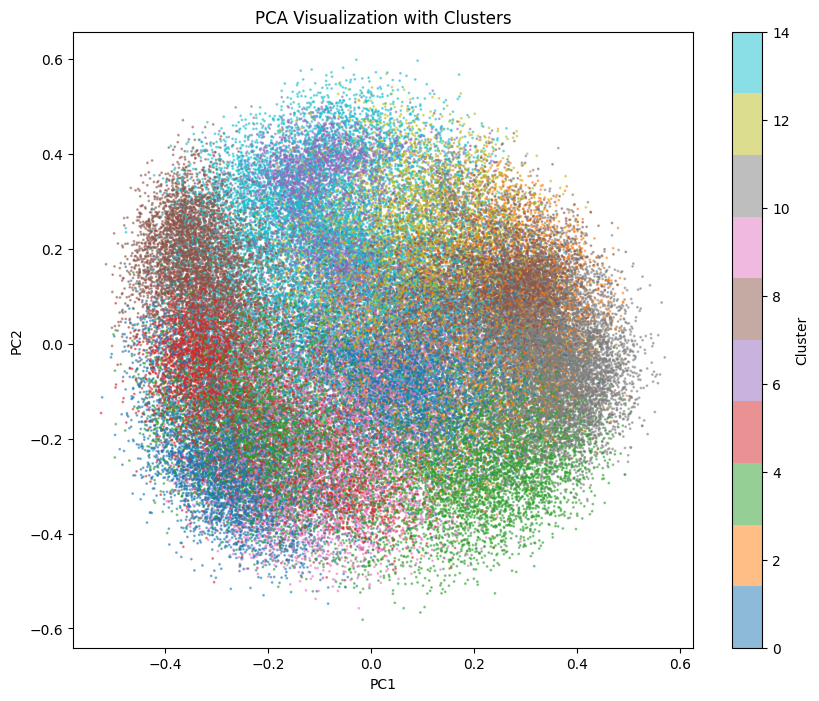

{'n_samples': 80000, 'n_components': 64, 'n_clusters': 15, 'kmeans_inertia': 47493.703125, 'mean_similarity': -0.001564576174132526, 'pct_sim_gt_08': 0.025, 'execution_time_sec': 87.90513586997986, 'metadata': {'sample_size': 80000, 'total_rows': 2535522, 'n_components': 64, 'n_clusters': 15, 'gpu_used': True, 'chunk_size': 10000, 'similarity_pairs_checked': 8000}}


In [ ]:
# Run analysis and get results
results = analyzer.run_heavy_math_on_sample()

# Check if analysis completed successfully
if results.is_complete():
    print("✅ Analysis completed successfully!")

    # Access data
    print(f"Analyzed {results.n_samples:,} samples")
    print(f"Found {results.n_clusters} clusters")

    # === XÓA HOẶC COMMENT PHẦN NÀY NẾU KHÔNG CÓ DATA MỚI ===
    # new_embeddings = ...  # your new data  <-- ĐÂY LÀ PLACEHOLDER
    # reduced_new = results.ipca_model.transform(new_embeddings)
    # clusters_new = results.kmeans_model.predict(reduced_new)

    # Visualize với data đã có
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    plt.scatter(
        results.reduced_embeddings[:, 0],
        results.reduced_embeddings[:, 1],
        c=results.cluster_labels,
        alpha=0.5,
        cmap='tab10',
        s=1
    )
    plt.colorbar(label='Cluster')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title("PCA Visualization with Clusters")
    plt.show()

    # Save results for later
    results.save("analysis_results.pkl")

    # Export to dict for logging
    result_dict = results.to_dict()
    print(result_dict)
else:
    print("⚠️ Analysis incomplete")
    print(results.metadata)